# New Section

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import preprocessing

#%% Preprocessing
# Load data
X_t = pd.read_csv("/content/X_t.csv")
X_tr = pd.read_csv("/content/X_tr.csv")
y_t = pd.read_csv("/content/y_t.csv")
y_tr = pd.read_csv("/content/y_tr.csv")

In [ ]:
X_tr.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,genre_is_Alternative,genre_is_Anime,genre_is_Blues,genre_is_Classical,genre_is_Comedy,genre_is_Country,genre_is_Dance,genre_is_Electronic,genre_is_Folk,genre_is_Hip-Hop,genre_is_Indie,genre_is_Jazz,genre_is_Movie,genre_is_Opera,genre_is_Pop,genre_is_R&B,genre_is_Rap,genre_is_Reggae,genre_is_Reggaeton,genre_is_Rock,genre_is_Ska,genre_is_Soul,genre_is_Soundtrack,genre_is_World,genre_is_Children_music,Mode_is_Major,time_sig_is_1/4,time_sig_is_3/4,time_sig_is_4/4,time_sig_is_5/4
0,0.980,0.334,229200,0.221,0.00399,11,0.1220,-17.479,0.0963,77.662,0.244,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.845,0.663,73000,0.326,0.30100,10,0.1110,-10.944,0.0652,170.141,0.510,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
2,0.722,0.333,353920,0.377,0.00000,6,0.0333,-8.282,0.0343,87.613,0.245,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.492,0.657,180600,0.625,0.00000,4,0.1550,-8.097,0.0527,73.999,0.504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.821,0.545,311680,0.697,0.00000,5,0.8740,-13.205,0.8590,87.403,0.493,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [2]:
# scaling the inputs - do it only for the continuous variables
X_tr_scaled = pd.DataFrame(preprocessing.scale(X_tr[['acousticness','danceability',
                                                     'duration_ms','energy',
                                                     'instrumentalness','liveness',
                                                     'loudness','speechiness','tempo',
                                                     'valence','key']]))

# keeping the column names
X_tr_scaled.columns = ['acousticness','danceability','duration_ms','energy',
                       'instrumentalness','liveness','loudness','speechiness',
                       'tempo','valence','key']

# adding the other columns (in their original form) to the scaled data
X_tr_scaled = pd.concat([X_tr_scaled, X_tr.iloc[:, 11:41]], axis=1)

In [ ]:
X_tr_scaled.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre_is_Alternative,genre_is_Anime,genre_is_Blues,genre_is_Classical,genre_is_Comedy,genre_is_Country,genre_is_Dance,genre_is_Electronic,genre_is_Folk,genre_is_Hip-Hop,genre_is_Indie,genre_is_Jazz,genre_is_Movie,genre_is_Opera,genre_is_Pop,genre_is_R&B,genre_is_Rap,genre_is_Reggae,genre_is_Reggaeton,genre_is_Rock,genre_is_Ska,genre_is_Soul,genre_is_Soundtrack,genre_is_World,genre_is_Children_music,Mode_is_Major,time_sig_is_1/4,time_sig_is_3/4,time_sig_is_4/4,time_sig_is_5/4
0,1.724054,-1.188015,-0.047814,-1.328889,-0.475608,-0.469598,-1.320875,-0.132213,-1.293844,-0.811619,1.619483,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1.343515,0.585104,-1.365344,-0.930257,0.506521,-0.525151,-0.229864,-0.299844,1.697575,0.211050,1.338934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
2,0.996802,-1.193404,1.004186,-0.736636,-0.488802,-0.917558,0.214554,-0.466397,-0.971959,-0.807774,0.216738,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.348477,0.552767,-0.457750,0.204895,-0.488802,-0.302938,0.245440,-0.367220,-1.412331,0.187982,-0.344360,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1.275864,-0.050847,0.647896,0.478242,-0.488802,3.328214,-0.607335,3.978783,-0.978752,0.145691,-0.063811,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
print(X_tr_scaled.shape, y_tr.shape)

(186180, 41) (186180, 1)


In [3]:
# importing models and evaluation metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoLars
from yellowbrick.regressor import ResidualsPlot

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# running linear regression without regularisation
linreg = LinearRegression()

# cross validation scores; 5 folds by default
print(np.mean(cross_val_score(linreg, X_tr, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(linreg, X_tr, y_tr, scoring=('neg_mean_squared_error')))) 

-124.69442794156524 0.6334484130810215


In [ ]:
# extracting R squared from base linear model
# running linear regression without regularisation
linreg = LinearRegression()

# cross validation scores; 5 folds by default
print(np.mean(cross_val_score(linreg, X_tr, y_tr, scoring=('r2'))), 
      np.std(cross_val_score(linreg, X_tr, y_tr)))

0.6220273874988727 0.0021653456819152365


In [ ]:
# running linear regression with l2 regularisation - ridge
ridge = Ridge(alpha=0.2, solver='svd')
print(np.mean(cross_val_score(ridge, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(ridge, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error')))) 

-124.69618153805376 0.6310388706781787


In [ ]:
# grid search
tuned_parameters = [{'alpha': [1e-4,1e-3, 1e-2,1e-1,1,1e+1,1e+2,1e+3]}]

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    mod = GridSearchCV(Ridge(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_tr_scaled, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

# Tuning hyper-parameters for neg_mean_squared_error

Best parameter set found:

{'alpha': 0.0001}

Grid scores in cross validation:

-124.694 (+/-0.633) for {'alpha': 0.0001}
-124.694 (+/-0.633) for {'alpha': 0.001}
-124.694 (+/-0.633) for {'alpha': 0.01}
-124.695 (+/-0.632) for {'alpha': 0.1}
-124.723 (+/-0.625) for {'alpha': 1}
-124.967 (+/-0.614) for {'alpha': 10.0}
-125.210 (+/-0.600) for {'alpha': 100.0}
-129.960 (+/-0.542) for {'alpha': 1000.0}



In [4]:
# running linear regression with l1 regularisation - lasso
lasso = Lasso(alpha=0.1)
print(np.mean(cross_val_score(lasso, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(lasso, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error')))) 

-132.61747284508888 0.6785593668235242


In [ ]:
# grid search
tuned_parameters = [{'alpha': [1e-11,1e-10,1e-9,1e-8, 1e-7,1e-6]}]

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
#(max_iter=1000000, tol=1e-1)
    mod = GridSearchCV(LassoLars(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_tr_scaled, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

# Tuning hyper-parameters for neg_mean_squared_error

Best parameter set found:

{'alpha': 1e-07}

Grid scores in cross validation:

-124.694 (+/-0.633) for {'alpha': 1e-11}
-124.694 (+/-0.633) for {'alpha': 1e-10}
-124.694 (+/-0.633) for {'alpha': 1e-09}
-124.694 (+/-0.633) for {'alpha': 1e-08}
-124.694 (+/-0.633) for {'alpha': 1e-07}
-124.701 (+/-0.629) for {'alpha': 1e-06}



In [ ]:
# running linear regression with elasticnet
elasticnet = ElasticNet(alpha=100, l1_ratio=100)
print(np.mean(cross_val_score(lasso, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(lasso, X_tr_scaled, y_tr, scoring=('neg_mean_squared_error')))) 

-261.4587327147814 0.9411437681907925


In [ ]:
# grid search
tuned_parameters = {'alpha': [1e-03,1e-2,1e-1,1], 'l1_ratio': [0.3,0.5,0.7]}

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
#(max_iter=1000000, tol=1e-1)
    mod = GridSearchCV(ElasticNet(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_tr_scaled, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

# Tuning hyper-parameters for neg_mean_squared_error

Best parameter set found:

{'alpha': 0.001, 'l1_ratio': 0.7}

Grid scores in cross validation:

-125.222 (+/-0.599) for {'alpha': 0.001, 'l1_ratio': 0.3}
-125.171 (+/-0.603) for {'alpha': 0.001, 'l1_ratio': 0.5}
-125.119 (+/-0.607) for {'alpha': 0.001, 'l1_ratio': 0.7}
-130.538 (+/-0.540) for {'alpha': 0.01, 'l1_ratio': 0.3}
-128.555 (+/-0.546) for {'alpha': 0.01, 'l1_ratio': 0.5}
-126.824 (+/-0.559) for {'alpha': 0.01, 'l1_ratio': 0.7}
-188.192 (+/-0.651) for {'alpha': 0.1, 'l1_ratio': 0.3}
-179.030 (+/-0.638) for {'alpha': 0.1, 'l1_ratio': 0.5}
-165.738 (+/-0.623) for {'alpha': 0.1, 'l1_ratio': 0.7}
-259.306 (+/-0.923) for {'alpha': 1, 'l1_ratio': 0.3}
-260.956 (+/-0.921) for {'alpha': 1, 'l1_ratio': 0.5}
-261.977 (+/-0.932) for {'alpha': 1, 'l1_ratio': 0.7}



In [ ]:
########################### polynomial regression - order 2

In [ ]:
# running polynomial regression (2) without regularisation - including all terms, even the dummies
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_tr_scaled)
X_poly.shape
# maybe rescale the poly terms
# maybe name the variables again and find a way to get variable names of poly terms

(186180, 903)

In [ ]:
# getting feature names from polynomial dataset
#poly.get_feature_names(X_tr_scaled.columns)
X_poly_df = pd.DataFrame(X_poly)
X_poly_df.columns = poly.get_feature_names(X_tr_scaled.columns)

In [ ]:
X_poly_df

,1,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre_is_Alternative,genre_is_Anime,genre_is_Blues,genre_is_Classical,genre_is_Comedy,genre_is_Country,genre_is_Dance,genre_is_Electronic,genre_is_Folk,genre_is_Hip-Hop,genre_is_Indie,genre_is_Jazz,genre_is_Movie,genre_is_Opera,genre_is_Pop,genre_is_R&B,genre_is_Rap,genre_is_Reggae,genre_is_Reggaeton,genre_is_Rock,genre_is_Ska,genre_is_Soul,genre_is_Soundtrack,genre_is_World,genre_is_Children_music,Mode_is_Major,time_sig_is_1/4,time_sig_is_3/4,...,genre_is_Soul time_sig_is_1/4,genre_is_Soul time_sig_is_3/4,genre_is_Soul time_sig_is_4/4,genre_is_Soul time_sig_is_5/4,genre_is_Soundtrack^2,genre_is_Soundtrack genre_is_World,genre_is_Soundtrack genre_is_Children_music,genre_is_Soundtrack Mode_is_Major,genre_is_Soundtrack time_sig_is_1/4,genre_is_Soundtrack time_sig_is_3/4,genre_is_Soundtrack time_sig_is_4/4,genre_is_Soundtrack time_sig_is_5/4,genre_is_World^2,genre_is_World genre_is_Children_music,genre_is_World Mode_is_Major,genre_is_World time_sig_is_1/4,genre_is_World time_sig_is_3/4,genre_is_World time_sig_is_4/4,genre_is_World time_sig_is_5/4,genre_is_Children_music^2,genre_is_Children_music Mode_is_Major,genre_is_Children_music time_sig_is_1/4,genre_is_Children_music time_sig_is_3/4,genre_is_Children_music time_sig_is_4/4,genre_is_Children_music time_sig_is_5/4,Mode_is_Major^2,Mode_is_Major time_sig_is_1/4,Mode_is_Major time_sig_is_3/4,Mode_is_Major time_sig_is_4/4,Mode_is_Major time_sig_is_5/4,time_sig_is_1/4^2,time_sig_is_1/4 time_sig_is_3/4,time_sig_is_1/4 time_sig_is_4/4,time_sig_is_1/4 time_sig_is_5/4,time_sig_is_3/4^2,time_sig_is_3/4 time_sig_is_4/4,time_sig_is_3/4 time_sig_is_5/4,time_sig_is_4/4^2,time_sig_is_4/4 time_sig_is_5/4,time_sig_is_5/4^2
0,1.0,1.724054,-1.188015,-0.047814,-1.328889,-0.475608,-0.469598,-1.320875,-0.132213,-1.293844,-0.811619,1.619483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.343515,0.585104,-1.365344,-0.930257,0.506521,-0.525151,-0.229864,-0.299844,1.697575,0.211050,1.338934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.996802,-1.193404,1.004186,-0.736636,-0.488802,-0.917558,0.214554,-0.466397,-0.971959,-0.807774,0.216738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.348477,0.552767,-0.457750,0.204895,-0.488802,-0.302938,0.245440,-0.367220,-1.412331,0.187982,-0.344360,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.275864,-0.050847,0.647896,0.478242,-0.488802,3.328214,-0.607335,3.978783,-0.978752,0.145691,-0.063811,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# non regularized linear model
print(np.mean(cross_val_score(linreg, X_poly_df, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(linreg, X_poly_df, y_tr, scoring=('neg_mean_squared_error'))))

-3.6401945559524154e+17 5.3322628829063635e+17


In [ ]:
# running polynomial regression with l2 regularisation - ridge
ridge = Ridge(alpha=1)
print(np.mean(cross_val_score(ridge, X_poly_df, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(ridge, X_poly_df, y_tr, scoring=('neg_mean_squared_error'))))

-102.64665796284541 0.7160989760567339


In [ ]:
# r-squared
ridge = Ridge(alpha=1)
print(np.mean(cross_val_score(ridge, X_poly, y_tr, scoring=('r2'))), 
      np.std(cross_val_score(ridge, X_poly, y_tr, scoring=('r2'))))

0.6888547312136923 0.002767391949754084


In [ ]:
# grid search
tuned_parameters = [{'alpha': [0.007]}]

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    mod = GridSearchCV(Ridge(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_poly, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

In [ ]:
# running polynomial regression with l1 regularisation - lasso
lasso = Lasso(alpha=1)
print(np.mean(cross_val_score(lasso, X_poly, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(lasso, X_poly, y_tr, scoring=('neg_mean_squared_error')))) 

-187.33220472636035 0.7576141352769256


In [ ]:
# grid search - Lars Lasso
tuned_parameters = [{'alpha': [0.002,0.003,0.004]}]

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
#(max_iter=1000000, tol=1e-1)
    mod = GridSearchCV(LassoLars(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_poly, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

In [ ]:
# running polynomial regression with l1 regularisation - lasso
lasso = LassoLars(alpha=0.002)
lasso.fit(X_poly_df, y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.133e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.523e-03, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.305e-03, with an active set of 32 regressors, and the smallest cholesky pivot el

LassoLars(alpha=0.002, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
          positive=False, precompute='auto', verbose=False)

In [ ]:
lasso.coef_

array([  0.        ,  -0.1281169 ,   0.02492371,   0.        ,
         0.        ,   0.        ,  -0.33568718,   1.35473328,
         0.        ,   0.        ,   0.        ,   0.        ,
         5.06064108, -11.30851875,  -1.17184039,  -1.31848092,
       -10.40365943,   0.70113748,  11.6301217 ,   0.        ,
         5.75257698,  13.48020331,  10.01748025,   0.        ,
       -21.39733181, -17.82977724,  21.35895433,   7.25493357,
        15.46882352,  -0.86340183,   0.        ,  14.49982631,
        -7.88952083,   2.3611975 ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.7574559 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [ ]:
# running linear regression with elasticnet
elasticnet = ElasticNet(alpha=100, l1_ratio=100)
print(np.mean(cross_val_score(lasso, X_poly, y_tr, scoring=('neg_mean_squared_error'))), 
      np.std(cross_val_score(lasso, X_poly, y_tr, scoring=('neg_mean_squared_error')))) 

In [ ]:
# grid search
tuned_parameters = {'alpha': [1e-03,1e-2,1e-1,1], 'l1_ratio': [0.3,0.5,0.7]}

scores = ['neg_mean_squared_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
#(max_iter=1000000, tol=1e-1)
    mod = GridSearchCV(ElasticNet(), tuned_parameters, scoring= score, cv=5)
    mod.fit(X_poly, y_tr)

    print("Best parameter set found:")
    print()
    print(mod.best_params_)
    print()
    print("Grid scores in cross validation:")
    print()
    means = mod.cv_results_['mean_test_score']
    stds = mod.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, mod.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std, params))
    print()

In [ ]:
# Feature importance of polynomial model (ridge, order 2), then linear model

In [ ]:
# running linear ridge model
model2 = Ridge(alpha=0.01)
model2.fit(X_poly_df, y_tr)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
# running polynomial regression with l2 regularisation - ridge
model = Ridge(alpha=0.001)
model.fit(X_poly_df, y_tr)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
# getting predictions from best model (Ridge polynomial) and storing in a dataframe for final test preduiction

In [ ]:
feature_names = poly.get_feature_names(X_tr_scaled.columns)
np.array(feature_names).shape

(903,)

In [ ]:
feature_names2 = list(X_tr_scaled.columns.values)
np.array(feature_names2).shape

(41,)

In [ ]:
model.coef_.T.shape

(903, 1)

In [ ]:
# coefficients for poly ridge model
coefs = pd.DataFrame(model.coef_.T, columns=['Coefficients'], index=feature_names)
coefs = coefs.sort_values(by=['Coefficients'], axis=0, ascending=False)
coefs.head(20)

,Coefficients
genre_is_Rap,26.825729
genre_is_Rap^2,26.825729
genre_is_Pop,26.678108
genre_is_Pop^2,26.678107
genre_is_Dance,26.316243
genre_is_Dance^2,26.316243
genre_is_Rock,25.931637
genre_is_Rock^2,25.931637
genre_is_Hip-Hop,24.766400
genre_is_Hip-Hop^2,24.766399


In [ ]:
# for linear ridge model:

In [ ]:
# coefficients for linear ridge model
coefs2 = pd.DataFrame(model2.coef_.T, columns=['Coefficients'] , index=feature_names2)
coefs2 = coefs2.sort_values(by=['Coefficients'], axis=0, ascending=False)
coefs2

,Coefficients
genre_is_Pop,54.309799
genre_is_Rap,48.546080
genre_is_Rock,47.047807
genre_is_Hip-Hop,46.766400
genre_is_Dance,44.492796
genre_is_Indie,42.662459
genre_is_R&B,40.424539
genre_is_Folk,38.757467
genre_is_Alternative,37.176719
genre_is_Soul,35.629889


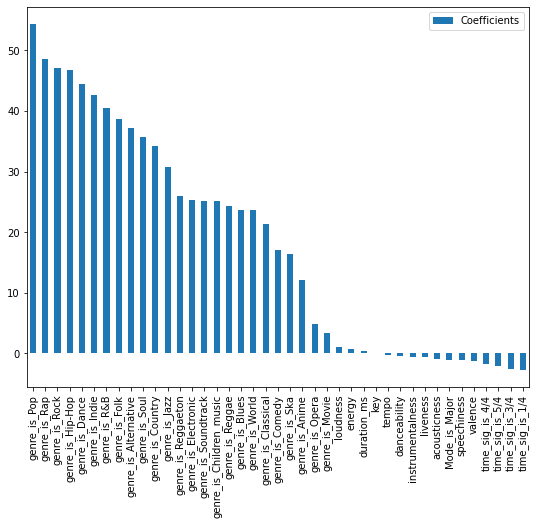

In [ ]:
from matplotlib import pyplot as plt
coefs2.plot(kind='bar', figsize=(9, 7))

In [ ]:
# std dev of feature * in descending order
coefs12 = pd.DataFrame(np.multiply(np.array(model2.coef_), np.array(X_tr_scaled.std(axis=0))).T, 
columns=['Coefficient importance'], index=feature_names2)
coefs12 = coefs12.sort_values(by=['Coefficient importance'], axis=0, ascending=False)
coefs12.head(20)

,Coefficient importance
genre_is_Pop,10.664281
genre_is_Rap,9.476143
genre_is_Rock,9.194996
genre_is_Hip-Hop,9.175407
genre_is_Indie,8.461490
genre_is_Dance,8.448412
genre_is_R&B,7.784505
genre_is_Folk,7.596759
genre_is_Alternative,7.270967
genre_is_Soul,6.911886


In [ ]:
# get predictions from ridge model; X_test has to be scaled according to X_train parameters and poly transform must be applied
means = X_tr[['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness',
                  'loudness','speechiness','tempo','valence']].mean(axis=0)
means

acousticness             0.368374
danceability             0.554435
duration_ms         234868.558916
energy                   0.571031
instrumentalness         0.147821
key                      5.227452
liveness                 0.214984
loudness                -9.567150
speechiness              0.120829
tempo                  117.660879
valence                  0.455105
dtype: float64

In [ ]:
std = X_tr[['acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness',
                  'loudness','speechiness','tempo','valence']].std(axis=0)
std

acousticness             0.354761
danceability             0.185549
duration_ms         118555.437405
energy                   0.263402
instrumentalness         0.302415
key                      3.564449
liveness                 0.198009
loudness                 5.989872
speechiness              0.185527
tempo                   30.914843
valence                  0.260105
dtype: float64

In [ ]:
# scale test set with this
X_t.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,genre_is_Alternative,genre_is_Anime,genre_is_Blues,genre_is_Classical,genre_is_Comedy,genre_is_Country,genre_is_Dance,genre_is_Electronic,genre_is_Folk,genre_is_Hip-Hop,genre_is_Indie,genre_is_Jazz,genre_is_Movie,genre_is_Opera,genre_is_Pop,genre_is_R&B,genre_is_Rap,genre_is_Reggae,genre_is_Reggaeton,genre_is_Rock,genre_is_Ska,genre_is_Soul,genre_is_Soundtrack,genre_is_World,genre_is_Children_music,Mode_is_Major,time_sig_is_1/4,time_sig_is_3/4,time_sig_is_4/4,time_sig_is_5/4
0,0.00792,0.861,170295,0.6050,0.269000,7,0.0555,-10.104,0.1430,129.844,0.817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.25900,0.820,205733,0.3720,0.000000,9,0.0880,-12.085,0.0874,109.632,0.871,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.19800,0.791,252933,0.5750,0.000006,9,0.0827,-12.167,0.0754,80.925,0.847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
3,0.95700,0.461,144640,0.0609,0.000000,7,0.1140,-29.027,0.0798,94.687,0.458,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.98200,0.368,320627,0.3820,0.010500,5,0.3240,-13.974,0.0983,106.018,0.274,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
range(X_tr.shape[0])

range(0, 186180)

In [ ]:
X_tr.iloc[2,0]

0.722

In [ ]:
outer_list = []
for i,j,k in zip(range(X_t.shape[1]), means, std):
    interior_list = []    
    for l in range(X_t.shape[0]): 
        a = (X_t.iloc[l,i] - j) / k
        interior_list.append(a)
    outer_list.append(interior_list) # after inner for loop is finished, append filled interior vector outside

In [ ]:
# get predicted values and scores by training on train data and testing on scaled test data from prev cell

In [ ]:
outer_list = np.array(outer_list)

In [ ]:
outer_list.T.shape

(46545, 11)

In [ ]:
X_t.shape

(46545, 41)

In [ ]:
a = pd.DataFrame(outer_list.T)

In [ ]:
a.columns = ['acousticness','danceability','duration_ms','energy',
                       'instrumentalness','liveness','loudness','speechiness',
                       'tempo','valence','key']

In [ ]:
a

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key
0,-1.016048,1.652204,-0.544670,0.128964,0.400705,0.497285,-0.805439,-0.089626,0.119502,0.394086,1.391344
1,-0.308304,1.431239,-0.245755,-0.755617,-0.488801,1.058382,-0.641306,-0.420351,-0.180184,-0.259710,1.598953
2,-0.480251,1.274946,0.152371,0.015070,-0.488782,1.058382,-0.668072,-0.434041,-0.244865,-1.188293,1.506682
3,1.659217,-0.503557,-0.761066,-1.936703,-0.488801,0.497285,-0.509999,-3.248792,-0.221148,-0.743134,0.011129
4,1.729687,-1.004772,0.723362,-0.717652,-0.454080,-0.063811,0.550558,-0.735717,-0.121433,-0.376611,-0.696278
...,...,...,...,...,...,...,...,...,...,...,...
46540,0.280825,1.059370,0.205798,-0.394951,-0.488510,-0.063811,-0.827660,0.045435,-0.482026,0.016113,1.845008
46541,-0.466157,0.035383,-0.133234,-0.250684,1.065354,-0.905456,0.560658,-0.603828,-0.374765,-0.403556,0.756983
46542,-1.035385,0.100056,0.209172,1.116050,-0.473292,-0.905456,-0.499898,0.579336,-0.090709,1.955505,0.618578
46543,-0.604278,1.253388,-0.111961,-0.250684,-0.488688,1.058382,-0.469596,0.740942,1.051980,-0.898108,1.099154


In [ ]:
# adding the other columns (in their original form) to the scaled data
X_t_scaled = pd.concat([a, X_t.iloc[:, 11:41]], axis=1)

In [ ]:
X_t_scaled.shape

(46545, 41)

In [ ]:
# creating the polynomial test frame

In [ ]:
polyt = PolynomialFeatures(2)
X_polyt = polyt.fit_transform(X_t_scaled)
X_polyt.shape
# maybe rescale the poly terms
# maybe name the variables again and find a way to get variable names of poly terms

(46545, 903)

In [ ]:
# getting feature names from polynomial dataset
X_polyt_df = pd.DataFrame(X_polyt)
X_polyt_df.columns = polyt.get_feature_names(X_t_scaled.columns)

In [ ]:
X_polyt_df

,1,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,genre_is_Alternative,genre_is_Anime,genre_is_Blues,genre_is_Classical,genre_is_Comedy,genre_is_Country,genre_is_Dance,genre_is_Electronic,genre_is_Folk,genre_is_Hip-Hop,genre_is_Indie,genre_is_Jazz,genre_is_Movie,genre_is_Opera,genre_is_Pop,genre_is_R&B,genre_is_Rap,genre_is_Reggae,genre_is_Reggaeton,genre_is_Rock,genre_is_Ska,genre_is_Soul,genre_is_Soundtrack,genre_is_World,genre_is_Children_music,Mode_is_Major,time_sig_is_1/4,time_sig_is_3/4,...,genre_is_Soul time_sig_is_1/4,genre_is_Soul time_sig_is_3/4,genre_is_Soul time_sig_is_4/4,genre_is_Soul time_sig_is_5/4,genre_is_Soundtrack^2,genre_is_Soundtrack genre_is_World,genre_is_Soundtrack genre_is_Children_music,genre_is_Soundtrack Mode_is_Major,genre_is_Soundtrack time_sig_is_1/4,genre_is_Soundtrack time_sig_is_3/4,genre_is_Soundtrack time_sig_is_4/4,genre_is_Soundtrack time_sig_is_5/4,genre_is_World^2,genre_is_World genre_is_Children_music,genre_is_World Mode_is_Major,genre_is_World time_sig_is_1/4,genre_is_World time_sig_is_3/4,genre_is_World time_sig_is_4/4,genre_is_World time_sig_is_5/4,genre_is_Children_music^2,genre_is_Children_music Mode_is_Major,genre_is_Children_music time_sig_is_1/4,genre_is_Children_music time_sig_is_3/4,genre_is_Children_music time_sig_is_4/4,genre_is_Children_music time_sig_is_5/4,Mode_is_Major^2,Mode_is_Major time_sig_is_1/4,Mode_is_Major time_sig_is_3/4,Mode_is_Major time_sig_is_4/4,Mode_is_Major time_sig_is_5/4,time_sig_is_1/4^2,time_sig_is_1/4 time_sig_is_3/4,time_sig_is_1/4 time_sig_is_4/4,time_sig_is_1/4 time_sig_is_5/4,time_sig_is_3/4^2,time_sig_is_3/4 time_sig_is_4/4,time_sig_is_3/4 time_sig_is_5/4,time_sig_is_4/4^2,time_sig_is_4/4 time_sig_is_5/4,time_sig_is_5/4^2
0,1.0,-1.016048,1.652204,-0.544670,0.128964,0.400705,0.497285,-0.805439,-0.089626,0.119502,0.394086,1.391344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,-0.308304,1.431239,-0.245755,-0.755617,-0.488801,1.058382,-0.641306,-0.420351,-0.180184,-0.259710,1.598953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,-0.480251,1.274946,0.152371,0.015070,-0.488782,1.058382,-0.668072,-0.434041,-0.244865,-1.188293,1.506682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.659217,-0.503557,-0.761066,-1.936703,-0.488801,0.497285,-0.509999,-3.248792,-0.221148,-0.743134,0.011129,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.729687,-1.004772,0.723362,-0.717652,-0.454080,-0.063811,0.550558,-0.735717,-0.121433,-0.376611,-0.696278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# fitting best model (poly 2 + ridge 0.001) to the dataset to get final prediction

In [ ]:
model = Ridge(alpha=120)
model.fit(X_poly_df, y_tr)

Ridge(alpha=120, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
#from google.colab import files
predictions = model.predict(X_polyt_df)
#predict = pd.DataFrame(data=predictions)
#predict.to_csv('lin_reg_pred.csv', index=False)
#files.download('lin_reg_pred.csv')

In [ ]:
# final result on test set
mean_squared_error(y_t, predictions)

137.65244871878323